In [1]:
import os
from os import path
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import torch
from generator import *
from discriminator import *
from feature_extractor import *
from dataset import *

from torch.utils.data import DataLoader
from torch.autograd import Variable
import sys
from torchvision.utils import save_image, make_grid
from torch.utils.tensorboard import SummaryWriter
print(os.getcwd())

/mnt/beta/djboonstoppel/Code


In [2]:
%load_ext autoreload
%autoreload 2

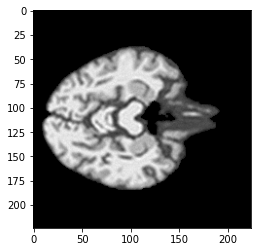

In [3]:
num = 100206
img = ImagePair(number=num, root_dir='data')
slice = img.img()['LR'][:,:,25]
plt.imshow(slice, cmap='gray')

In [4]:
transform = transforms.Compose([
    ToTensor(),
])

tra_set = ImagePairDataset('training', transform=transform)
val_set = ImagePairDataset('validation', transform=transform)

Load validation set	: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.02it/s]


Length of training set: 	7000
Length of validation set: 	1500


(-0.5, 223.5, 223.5, -0.5)

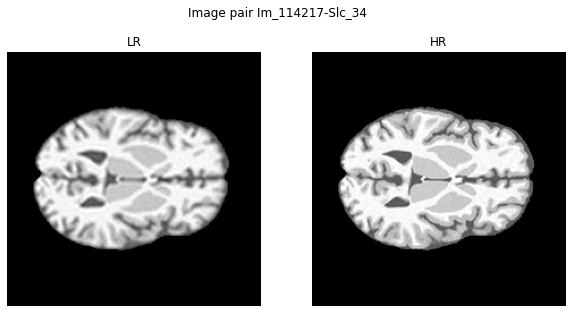

In [5]:
print('Length of training set: \t{}\nLength of validation set: \t{}'
      .format(len(tra_set),len(val_set)))

num = 25
sample = tra_set[num]
title = 'Image pair {}'.format(sample['id'])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.set_facecolor('white')
fig.suptitle(title)
ax1.imshow(np.squeeze(sample['LR']),cmap='gray')
ax1.set_title('LR')
ax1.axis('off')
ax2.imshow(np.squeeze(sample['HR']),cmap ='gray')
ax2.set_title('HR')
ax2.axis('off')

In [6]:
num = 25
sample = tra_set[num]
testlr=sample['LR']
testlr=np.repeat(testlr, 3, 0)
print(testlr.shape)

torch.Size([3, 224, 224])


In [7]:
batch_size = 4
n_cpu = 2
tra_dataloader = DataLoader(
    tra_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)

val_dataloader = DataLoader(
    val_set,
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu,
)


In [8]:
from torchsummary import summary
generator = GeneratorRRDB(channels=1, filters=64, num_res_blocks=1).cuda()
summary(generator, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
         LeakyReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
         LeakyReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 224, 224]          36,928
         LeakyReLU-6         [-1, 64, 224, 224]               0
            Conv2d-7         [-1, 64, 224, 224]          36,928
         LeakyReLU-8         [-1, 64, 224, 224]               0
            Conv2d-9         [-1, 64, 224, 224]          73,792
        LeakyReLU-10         [-1, 64, 224, 224]               0
           Conv2d-11         [-1, 64, 224, 224]         110,656
        LeakyReLU-12         [-1, 64, 224, 224]               0
           Conv2d-13         [-1, 64, 224, 224]         147,520
        LeakyReLU-14         [-1, 64, 2

In [9]:
discriminator = Discriminator(input_shape=(1,224,224)).cuda()
summary(discriminator, (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]             640
         LeakyReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 112, 112]          36,928
       BatchNorm2d-4         [-1, 64, 112, 112]             128
         LeakyReLU-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
       BatchNorm2d-7        [-1, 128, 112, 112]             256
         LeakyReLU-8        [-1, 128, 112, 112]               0
            Conv2d-9          [-1, 128, 56, 56]         147,584
      BatchNorm2d-10          [-1, 128, 56, 56]             256
        LeakyReLU-11          [-1, 128, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]         295,168
      BatchNorm2d-13          [-1, 256, 56, 56]             512
        LeakyReLU-14          [-1, 256,

In [10]:
# writer = SummaryWriter('runs/model_vis')
# writer.add_graph(discriminator, lr.cuda())
# writer.close()

In [21]:
lr = 0.0002
b1 = 0.9
b2 = 0.999
epochs = 10
warmup_batches = 100
lambda_adv = 5e-3
lambda_pixel = 1e-2
sample_interval = 100
checkpoint_interval = 1000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = GeneratorRRDB(channels=1, filters=64, num_res_blocks=1).to(device)
discriminator = Discriminator(input_shape=(1,224,224)).to(device)
feature_extractor = FeatureExtractor().to(device)

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.BCEWithLogitsLoss().to(device)
criterion_content = torch.nn.L1Loss().to(device)
criterion_pixel = torch.nn.L1Loss().to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

In [22]:
os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

In [ ]:
for epoch in range(epochs):
    for i, imgs in enumerate(tra_dataloader):

        batches_done = epoch * len(tra_dataloader) + i

        # Configure model input
        imgs_lr = Variable(imgs['LR'].type(Tensor))
        imgs_hr = Variable(imgs['HR'].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        # ------------------
        #  Train Generators
        # ------------------

        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        gen_hr = generator(imgs_lr)

        # Measure pixel-wise loss against ground truth
        loss_pixel = criterion_pixel(gen_hr, imgs_hr)

        if batches_done < warmup_batches:
            # Warm-up (pixel-wise loss only)
            loss_pixel.backward()
            optimizer_G.step()
            print(
                "[Epoch %d/%d] [Batch %d/%d] [G pixel: %f]"
                % (epoch, epochs, i, len(tra_dataloader), loss_pixel.item())
            )
            continue

        # Extract validity predictions from discriminator
        pred_real = discriminator(imgs_hr).detach()
        pred_fake = discriminator(gen_hr)

        # Adversarial loss (relativistic average GAN)
        loss_GAN = criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True), valid)

        # Content loss
        gen_features = feature_extractor(torch.repeat_interleave(gen_hr,3,1))
        real_features = feature_extractor(torch.repeat_interleave(imgs_hr,3,1)).detach()
        loss_content = criterion_content(gen_features, real_features)

        # Total generator loss
        loss_G = loss_content + lambda_adv * loss_GAN + lambda_pixel * loss_pixel

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        pred_real = discriminator(imgs_hr)
        pred_fake = discriminator(gen_hr.detach())

        # Adversarial loss for real and fake images (relativistic average GAN)
        loss_real = criterion_GAN(pred_real - pred_fake.mean(0, keepdim=True), valid)
        loss_fake = criterion_GAN(pred_fake - pred_real.mean(0, keepdim=True), fake)

        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        # --------------
        #  Log Progress
        # --------------

        print(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, content: %f, adv: %f, pixel: %f]"
            % (
                epoch,
                epochs,
                i,
                len(tra_dataloader),
                loss_D.item(),
                loss_G.item(),
                loss_content.item(),
                loss_GAN.item(),
                loss_pixel.item(),
            )
        )

        if batches_done % sample_interval == 0:
            # Save image grid with upsampled inputs and ESRGAN outputs
            # imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
            img_grid = torch.cat((imgs_lr, imgs_hr, gen_hr, (imgs_hr-gen_hr)), -1)
            path = os.path.join(os.getcwd(), 'images', '%d.png' % batches_done)
            save_image(img_grid, path, nrow=1, normalize=False)
        if batches_done % checkpoint_interval == 0:
            # Save model checkpoints
            torch.save(generator.state_dict(), "saved_models/generator_%d.pth" % epoch)
            torch.save(discriminator.state_dict(), "saved_models/discriminator_%d.pth" %epoch)

[Epoch 0/10] [Batch 0/1750] [G pixel: 0.009659]
[Epoch 0/10] [Batch 1/1750] [G pixel: 0.009987]
[Epoch 0/10] [Batch 2/1750] [G pixel: 0.010928]
[Epoch 0/10] [Batch 3/1750] [G pixel: 0.009628]
[Epoch 0/10] [Batch 4/1750] [G pixel: 0.012038]
[Epoch 0/10] [Batch 5/1750] [G pixel: 0.011822]
[Epoch 0/10] [Batch 6/1750] [G pixel: 0.012635]
[Epoch 0/10] [Batch 7/1750] [G pixel: 0.011067]
[Epoch 0/10] [Batch 8/1750] [G pixel: 0.009339]
[Epoch 0/10] [Batch 9/1750] [G pixel: 0.010333]
[Epoch 0/10] [Batch 10/1750] [G pixel: 0.011538]
[Epoch 0/10] [Batch 11/1750] [G pixel: 0.010656]
[Epoch 0/10] [Batch 12/1750] [G pixel: 0.011465]
[Epoch 0/10] [Batch 13/1750] [G pixel: 0.009138]
[Epoch 0/10] [Batch 14/1750] [G pixel: 0.012501]
[Epoch 0/10] [Batch 15/1750] [G pixel: 0.011614]
[Epoch 0/10] [Batch 16/1750] [G pixel: 0.010191]
[Epoch 0/10] [Batch 17/1750] [G pixel: 0.012736]
[Epoch 0/10] [Batch 18/1750] [G pixel: 0.011713]
[Epoch 0/10] [Batch 19/1750] [G pixel: 0.010073]
[Epoch 0/10] [Batch 20/1750] [